In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from neuode.interface.common import *
from neuode.interface.struct import *
from neuode.util.logging import logger
import neuode.util.logging as logging
import neuode.function.conv as conv
import neuode.ode.odeblock as odeblock

In [2]:
DPATH = '~/Documents/dataset'
BATCH_TRAIN_SIZE = 64
DIGIT = 0
C_AUGMENT = 3

class MNISTDigit(torch.utils.data.Dataset):
    
    def __init__(self, mnist, digit, augment):
        self.mnist = mnist
        self.digit = digit
        self.augment = augment
        
        self.idxs = []
        for i, (_, label) in enumerate(self.mnist):
            if label == self.digit:
                self.idxs.append(i)
                
    def __len__(self):
        return len(self.idxs)
        
    def __getitem__(self, idx):
        img, label = self.mnist[self.idxs[idx]]
        return self.augment_image(img), label
    
#     def __iter__(self):
#         for img, label in self.mnist:
#             if label == self.digit:
#                 yield self.augment_image(img), label

    def augment_image(self, img):
        channels, height, width = img.shape
        img_aug = torch.zeros(self.augment, height, width)
        return torch.cat([img, img_aug], 0)
        

mnist = torchvision.datasets.MNIST(DPATH, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
dmnist = MNISTDigit(mnist, DIGIT, C_AUGMENT)

train_loader = torch.utils.data.DataLoader(dmnist, batch_size=BATCH_TRAIN_SIZE, shuffle=True)

Text(0.5, 1.0, 'digit= 0')

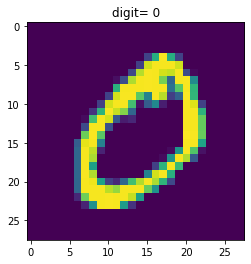

In [3]:
# principle digit (mean)
ideal_digit, label = dmnist[0]
plt.imshow(ideal_digit[0, ...])
plt.title('digit= %d'%label)

In [68]:
# build model
cfn_specs = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE),
]
ode_spec = ODEBlockSpec(use_adjoint=True)
cfn = conv.FullConvDMap(cfn_specs)
net = odeblock.ODEBlock(cfn, ode_spec)

In [39]:
# build time-dependent model
cfn_specs_t = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE, use_time=True),
]
ode_spec_t = ODEBlockSpec(use_adjoint=True)
cfn_t = conv.FullConvDMap(cfn_specs_t)
net_t = odeblock.ODEBlock(cfn_t, ode_spec_t)

In [75]:
# train
def train(net):
    lr, momentum = 0.01, 0.9
    net.train()
    for epoch in range(20):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(train_loader)
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = net(data)
            loss = criterion(pred[:, 0, ...], ideal_digit.repeat(len(data), 1, 1, 1)[:, 0, ...])
            loss.backward()
            optimizer.step()
            if batch_idx%1 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))
            if batch_idx%5 == 0:
                plot_check(net, 10)
                plt.show()

Epoch   0 [   0/  93 ( 0%)]: loss= 0.354913


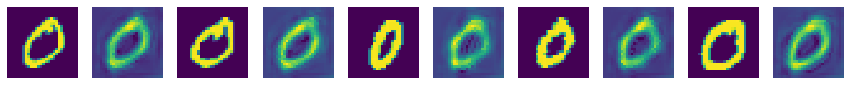

Epoch   0 [   1/  93 ( 1%)]: loss= 0.365679
Epoch   0 [   2/  93 ( 2%)]: loss= 0.341963
Epoch   0 [   3/  93 ( 3%)]: loss= 0.349500
Epoch   0 [   4/  93 ( 4%)]: loss= 0.373085
Epoch   0 [   5/  93 ( 5%)]: loss= 0.346547


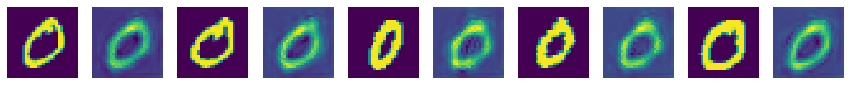

Epoch   0 [   6/  93 ( 6%)]: loss= 0.341260
Epoch   0 [   7/  93 ( 7%)]: loss= 0.348714
Epoch   0 [   8/  93 ( 8%)]: loss= 0.335692
Epoch   0 [   9/  93 ( 9%)]: loss= 0.345897
Epoch   0 [  10/  93 (10%)]: loss= 0.354799


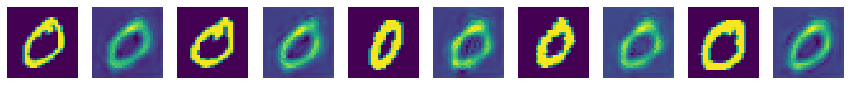

Epoch   0 [  11/  93 (11%)]: loss= 0.362120
Epoch   0 [  12/  93 (12%)]: loss= 0.326033
Epoch   0 [  13/  93 (13%)]: loss= 0.342977
Epoch   0 [  14/  93 (15%)]: loss= 0.401823
Epoch   0 [  15/  93 (16%)]: loss= 0.394216


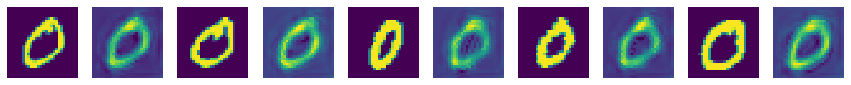

Epoch   0 [  16/  93 (17%)]: loss= 0.334536
Epoch   0 [  17/  93 (18%)]: loss= 0.443955
Epoch   0 [  18/  93 (19%)]: loss= 0.367023
Epoch   0 [  19/  93 (20%)]: loss= 0.403810
Epoch   0 [  20/  93 (21%)]: loss= 0.334270


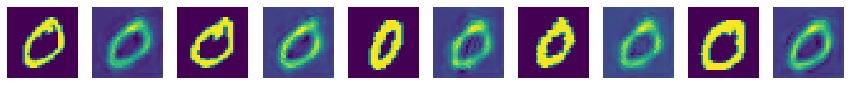

Epoch   0 [  21/  93 (22%)]: loss= 0.379021
Epoch   0 [  22/  93 (23%)]: loss= 0.383704
Epoch   0 [  23/  93 (24%)]: loss= 0.393447
Epoch   0 [  24/  93 (25%)]: loss= 0.417514
Epoch   0 [  25/  93 (26%)]: loss= 0.353889


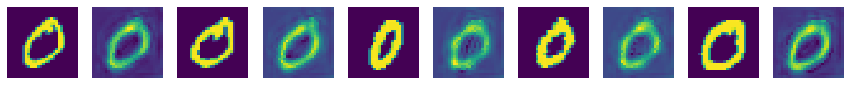

Epoch   0 [  26/  93 (27%)]: loss= 0.404253
Epoch   0 [  27/  93 (29%)]: loss= 0.353565
Epoch   0 [  28/  93 (30%)]: loss= 0.401143
Epoch   0 [  29/  93 (31%)]: loss= 0.314248
Epoch   0 [  30/  93 (32%)]: loss= 0.342581


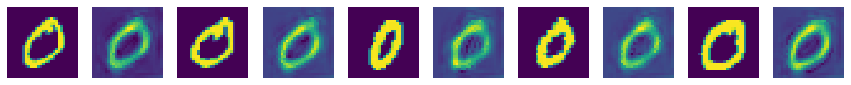

Epoch   0 [  31/  93 (33%)]: loss= 0.340053
Epoch   0 [  32/  93 (34%)]: loss= 0.332054
Epoch   0 [  33/  93 (35%)]: loss= 0.298541
Epoch   0 [  34/  93 (36%)]: loss= 0.313066
Epoch   0 [  35/  93 (37%)]: loss= 0.301374


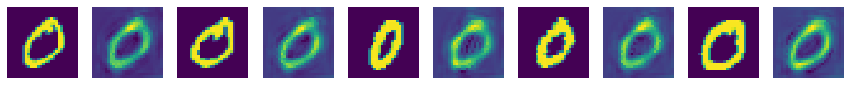

Epoch   0 [  36/  93 (38%)]: loss= 0.295603
Epoch   0 [  37/  93 (39%)]: loss= 0.308495
Epoch   0 [  38/  93 (40%)]: loss= 0.281424
Epoch   0 [  39/  93 (41%)]: loss= 0.290306
Epoch   0 [  40/  93 (43%)]: loss= 0.311463


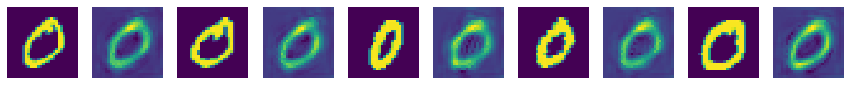

Epoch   0 [  41/  93 (44%)]: loss= 0.272256
Epoch   0 [  42/  93 (45%)]: loss= 0.262143
Epoch   0 [  43/  93 (46%)]: loss= 0.296436
Epoch   0 [  44/  93 (47%)]: loss= 0.295851
Epoch   0 [  45/  93 (48%)]: loss= 0.283974


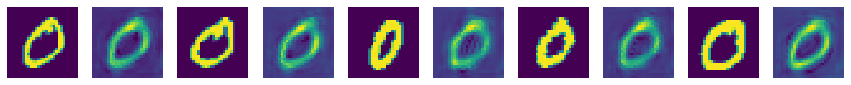

Epoch   0 [  46/  93 (49%)]: loss= 0.308395
Epoch   0 [  47/  93 (50%)]: loss= 0.363457
Epoch   0 [  48/  93 (51%)]: loss= 0.440012
Epoch   0 [  49/  93 (52%)]: loss= 0.334618
Epoch   0 [  50/  93 (53%)]: loss= 0.444102


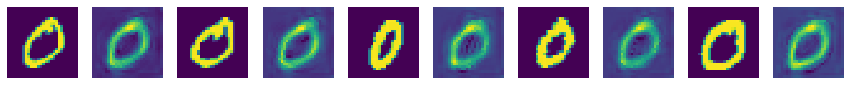

Epoch   0 [  51/  93 (54%)]: loss= 0.324293
Epoch   0 [  52/  93 (55%)]: loss= 0.396106
Epoch   0 [  53/  93 (56%)]: loss= 0.282061
Epoch   0 [  54/  93 (58%)]: loss= 0.444219
Epoch   0 [  55/  93 (59%)]: loss= 0.323379


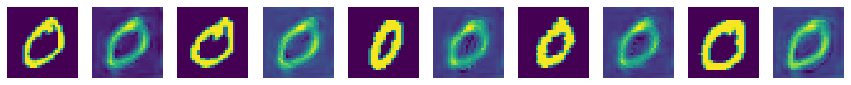

Epoch   0 [  56/  93 (60%)]: loss= 0.418298
Epoch   0 [  57/  93 (61%)]: loss= 0.366667
Epoch   0 [  58/  93 (62%)]: loss= 0.389963
Epoch   0 [  59/  93 (63%)]: loss= 0.390472
Epoch   0 [  60/  93 (64%)]: loss= 0.346289


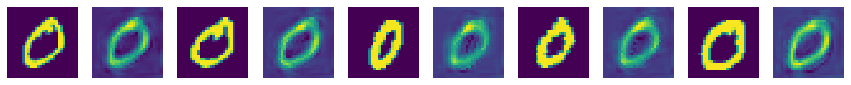

Epoch   0 [  61/  93 (65%)]: loss= 0.401607
Epoch   0 [  62/  93 (66%)]: loss= 0.351159
Epoch   0 [  63/  93 (67%)]: loss= 0.367452
Epoch   0 [  64/  93 (68%)]: loss= 0.356271
Epoch   0 [  65/  93 (69%)]: loss= 0.330641


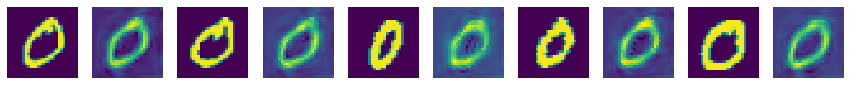

Epoch   0 [  66/  93 (70%)]: loss= 0.357136
Epoch   0 [  67/  93 (72%)]: loss= 0.309579
Epoch   0 [  68/  93 (73%)]: loss= 0.350494
Epoch   0 [  69/  93 (74%)]: loss= 0.314875
Epoch   0 [  70/  93 (75%)]: loss= 0.314042


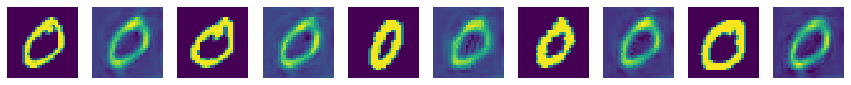

Epoch   0 [  71/  93 (76%)]: loss= 0.315419
Epoch   0 [  72/  93 (77%)]: loss= 0.352727
Epoch   0 [  73/  93 (78%)]: loss= 0.348842
Epoch   0 [  74/  93 (79%)]: loss= 0.357774
Epoch   0 [  75/  93 (80%)]: loss= 0.339434


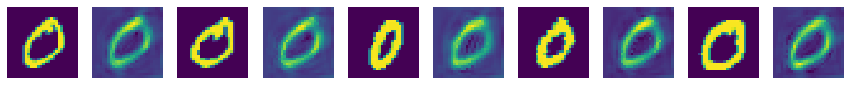

Epoch   0 [  76/  93 (81%)]: loss= 0.359783
Epoch   0 [  77/  93 (82%)]: loss= 0.296429
Epoch   0 [  78/  93 (83%)]: loss= 0.329722
Epoch   0 [  79/  93 (84%)]: loss= 0.316212
Epoch   0 [  80/  93 (86%)]: loss= 0.304472


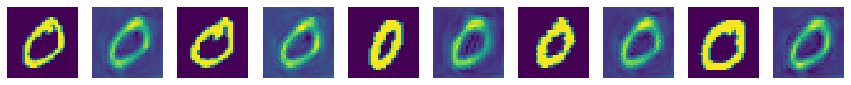

Epoch   0 [  81/  93 (87%)]: loss= 0.321754
Epoch   0 [  82/  93 (88%)]: loss= 0.317284
Epoch   0 [  83/  93 (89%)]: loss= 0.338758
Epoch   0 [  84/  93 (90%)]: loss= 0.380131
Epoch   0 [  85/  93 (91%)]: loss= 0.360310


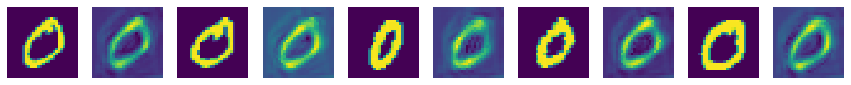

Epoch   0 [  86/  93 (92%)]: loss= 0.364645
Epoch   0 [  87/  93 (93%)]: loss= 0.350298
Epoch   0 [  88/  93 (94%)]: loss= 0.358240
Epoch   0 [  89/  93 (95%)]: loss= 0.337062
Epoch   0 [  90/  93 (96%)]: loss= 0.334344


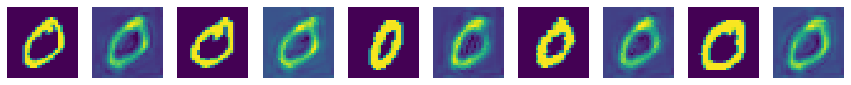

Epoch   0 [  91/  93 (97%)]: loss= 0.365397
Epoch   0 [  92/  93 (98%)]: loss= 0.328221
Epoch   1 [   0/  93 ( 0%)]: loss= 0.360497


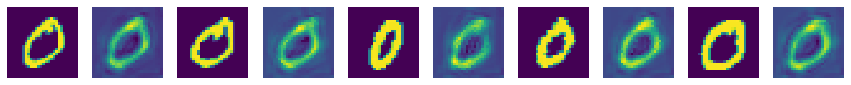

Epoch   1 [   1/  93 ( 1%)]: loss= 0.315595
Epoch   1 [   2/  93 ( 2%)]: loss= 0.410013
Epoch   1 [   3/  93 ( 3%)]: loss= 0.388062
Epoch   1 [   4/  93 ( 4%)]: loss= 0.347983
Epoch   1 [   5/  93 ( 5%)]: loss= 0.377266


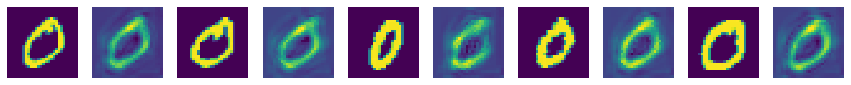

Epoch   1 [   6/  93 ( 6%)]: loss= 0.369111
Epoch   1 [   7/  93 ( 7%)]: loss= 0.342388
Epoch   1 [   8/  93 ( 8%)]: loss= 0.324026
Epoch   1 [   9/  93 ( 9%)]: loss= 0.384346
Epoch   1 [  10/  93 (10%)]: loss= 0.331828


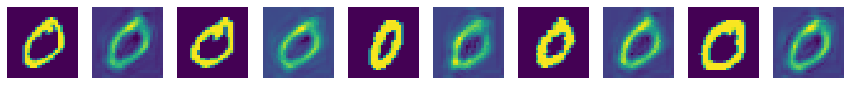

Epoch   1 [  11/  93 (11%)]: loss= 0.382467
Epoch   1 [  12/  93 (12%)]: loss= 0.483387
Epoch   1 [  13/  93 (13%)]: loss= 0.373280
Epoch   1 [  14/  93 (15%)]: loss= 0.473115
Epoch   1 [  15/  93 (16%)]: loss= 0.401027


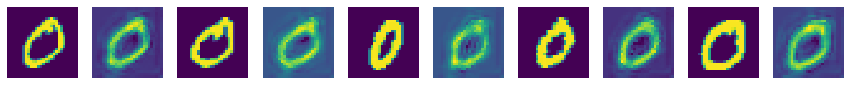

Epoch   1 [  16/  93 (17%)]: loss= 0.384891
Epoch   1 [  17/  93 (18%)]: loss= 0.410808
Epoch   1 [  18/  93 (19%)]: loss= 0.344456
Epoch   1 [  19/  93 (20%)]: loss= 0.431440
Epoch   1 [  20/  93 (21%)]: loss= 0.323926


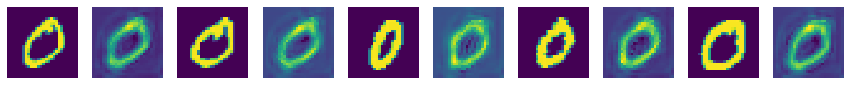

Epoch   1 [  21/  93 (22%)]: loss= 0.363286
Epoch   1 [  22/  93 (23%)]: loss= 0.365832
Epoch   1 [  23/  93 (24%)]: loss= 0.390572
Epoch   1 [  24/  93 (25%)]: loss= 0.370063
Epoch   1 [  25/  93 (26%)]: loss= 0.347720


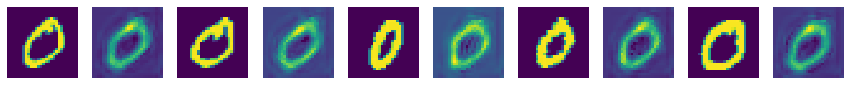

Epoch   1 [  26/  93 (27%)]: loss= 0.342824
Epoch   1 [  27/  93 (29%)]: loss= 0.314165
Epoch   1 [  28/  93 (30%)]: loss= 0.328605
Epoch   1 [  29/  93 (31%)]: loss= 0.313500
Epoch   1 [  30/  93 (32%)]: loss= 0.316046


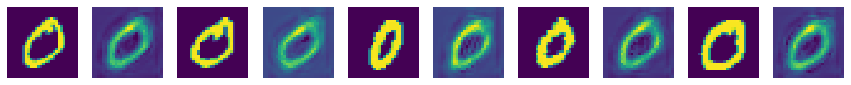

Epoch   1 [  31/  93 (33%)]: loss= 0.313971
Epoch   1 [  32/  93 (34%)]: loss= 0.308734
Epoch   1 [  33/  93 (35%)]: loss= 0.287997
Epoch   1 [  34/  93 (36%)]: loss= 0.298412
Epoch   1 [  35/  93 (37%)]: loss= 0.290130


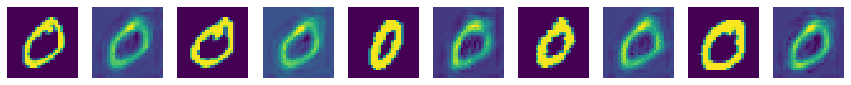

Epoch   1 [  36/  93 (38%)]: loss= 0.303861
Epoch   1 [  37/  93 (39%)]: loss= 0.297556
Epoch   1 [  38/  93 (40%)]: loss= 0.312582
Epoch   1 [  39/  93 (41%)]: loss= 0.292722
Epoch   1 [  40/  93 (43%)]: loss= 0.264933


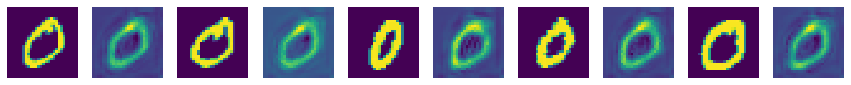

Epoch   1 [  41/  93 (44%)]: loss= 0.265103
Epoch   1 [  42/  93 (45%)]: loss= 0.275090
Epoch   1 [  43/  93 (46%)]: loss= 0.298055
Epoch   1 [  44/  93 (47%)]: loss= 0.269462
Epoch   1 [  45/  93 (48%)]: loss= 0.246162


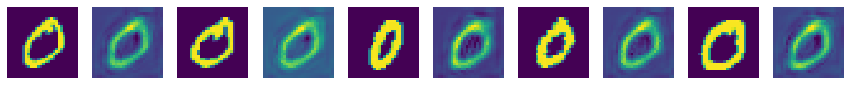

Epoch   1 [  46/  93 (49%)]: loss= 0.270103
Epoch   1 [  47/  93 (50%)]: loss= 0.281556
Epoch   1 [  48/  93 (51%)]: loss= 0.276986
Epoch   1 [  49/  93 (52%)]: loss= 0.280530
Epoch   1 [  50/  93 (53%)]: loss= 0.339129


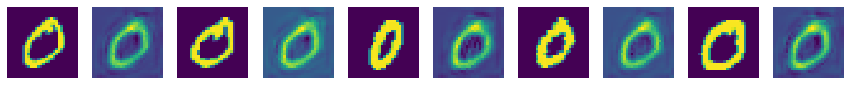

Epoch   1 [  51/  93 (54%)]: loss= 0.341766
Epoch   1 [  52/  93 (55%)]: loss= 0.437552
Epoch   1 [  53/  93 (56%)]: loss= 0.428420
Epoch   1 [  54/  93 (58%)]: loss= 0.544449
Epoch   1 [  55/  93 (59%)]: loss= 0.438595


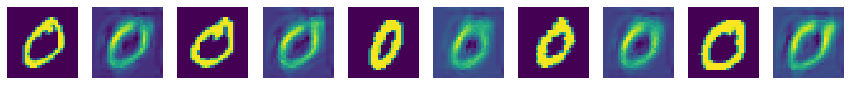

Epoch   1 [  56/  93 (60%)]: loss= 0.567380
Epoch   1 [  57/  93 (61%)]: loss= 0.411592
Epoch   1 [  58/  93 (62%)]: loss= 0.418045
Epoch   1 [  59/  93 (63%)]: loss= 0.512292
Epoch   1 [  60/  93 (64%)]: loss= 0.940910


AssertionError: max_num_steps exceeded (1000>=1000)

In [86]:
train(net)

In [ ]:
train(net_t)

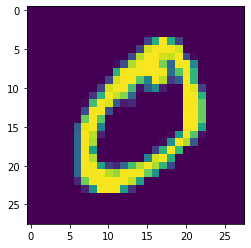

In [110]:
plt.imshow(ideal_digit[0])

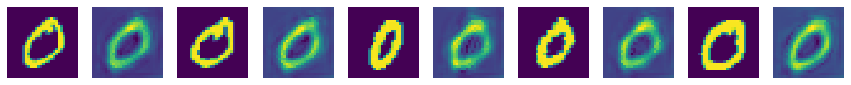

In [85]:
def plot_check(NET, NX):
    with torch.no_grad():
        # generate initial point and find trajectory
        OFFSET = 0
        L, R, NT = 0.0, 1.0, 2
        x0 = torch.stack([dmnist[i][0] for i in range(OFFSET, OFFSET+NX)])
        traj = NET.trajectory(x0, L, R, NT).numpy()
        
#     print(np.mean((traj[-1, :, 0, ...] - ideal_digit.repeat(10, 1, 1, 1)[:, 0, ...].numpy())**2))

    NC, SZ = 5, 1.5
    NR = (NX - 1) // (2*NC) + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        logging.render_video(traj[:, i, ...], path='/home/mixs/Documents/research/neuode/dump/digit_%d.mp4'%i)
        ax0.imshow(traj[0, i, 0, ...])
        ax1.imshow(traj[-1, i, 0, ...])
    for ax in axes:
        ax.axis('off')
        
plot_check(net, 10)

In [137]:
net.spec.max_num_step = 2000